In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
from hmmlearn import hmm

plt.rcParams["figure.figsize"] = (12, 9) 

In [2]:
# load in data, convert Date to datetime type
spy = pd.read_csv("../Data/spy_processed.csv")
spy["Date"] = pd.to_datetime(spy["Date"])

In [3]:
# log transform some columns
spy["volume_dev"] = np.log(spy["volume_dev"])
spy["range"] = np.log(spy["range"])
spy["var"] = np.log(spy["var"])

In [4]:
# take relevent columns
X = spy[["Date","Adj Close","ret","volume_dev","range","var"]]

In [5]:
# create HMM
class HMM:
    def __init__(self,n_comp):
        self.hmm = hmm.GaussianHMM(n_components=n_comp, covariance_type="full",n_iter=1000)
        self.n_comp = n_comp
        self.data = X[["ret","volume_dev","range","var"]]
        self.start = 0
        self.end = X.shape[0]
        self.dates = X["Date"]
        self.adj_close = X["Adj Close"]
        self.states = 0
    
    # fit the HMM to a range of indices (start, end)
    def fit_range(self, start, end):
        self.hmm = hmm.GaussianHMM(n_components=self.n_comp, covariance_type="full",n_iter=1000)
        self.start = start
        self.end = end
        self.hmm.fit(self.data.iloc[start:end,:])
        self.states = self.hmm.predict(self.data.iloc[start:end,:])
    
    # predict the next close AFTER running fit_range
    def predict_next_close(self):
        means = self.hmm.means_[:,0]
        probs = self.hmm.predict_proba(self.data.iloc[self.start:self.end,:])[self.end-self.start-1,:]
        pred_ret = np.dot(means, probs)
        pred_close = self.adj_close[self.end-1] * (1+pred_ret)
        return pred_close
    
    # plot predicted states onto graph of adjusted close. 
    # run fit_range before running this.
    def plot_states(self, dot_size=3):
        plt.plot(self.dates[self.start:self.end], self.adj_close[self.start:self.end], zorder=1, c="grey")
        plt.scatter(self.dates[self.start:self.end], self.adj_close[self.start:self.end], c=self.states, zorder=2, s=dot_size)
        plt.ylabel("Adjusted Close")
    
    # predict the next n days by training the hmm on the previous lag window of data.
    # then, predicts the stock price the following day
    # returns a data frame of predicted and actual stock prices
    # also comes with plot option
    def predict_next_n_days(self, n, begin_ind, lag, show_plot=False):
        ret = []
        for i in range(n):
            self.fit_range(begin_ind-lag+i, begin_ind+i)
            pred = self.predict_next_close()
            actual = self.adj_close[self.end]
            ret.append({"pred":pred, "actual":actual})
        ret = pd.DataFrame(ret)
        
        if show_plot:
            plt.plot(self.dates[begin_ind:begin_ind+n], ret["pred"],"o-", markersize=3, label="predicted")
            plt.plot(self.dates[begin_ind:begin_ind+n], ret["actual"], "o-", markersize=3, label="actual")
            plt.ylabel("Adjusted Close")
            plt.legend(loc="lower right", fontsize=20)
            
        return ret
    

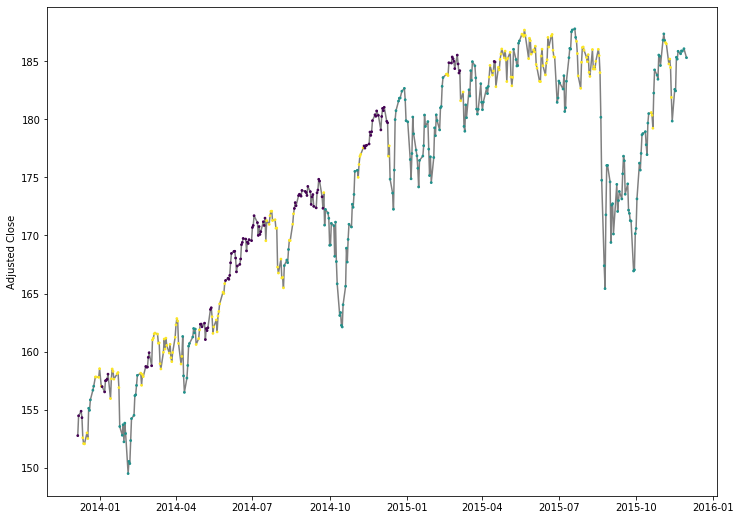

In [6]:
t = HMM(n_comp=3)
t.fit_range(5000,5500)
t.plot_states()

,pred,actual
0,153.385789,152.770416
1,152.710220,154.477875
2,154.501906,154.870636
3,154.915495,154.315674
4,154.396783,152.582535
...,...,...
95,161.918578,161.942429
96,162.135766,160.614670
97,160.849769,161.123398
98,161.358015,161.873459


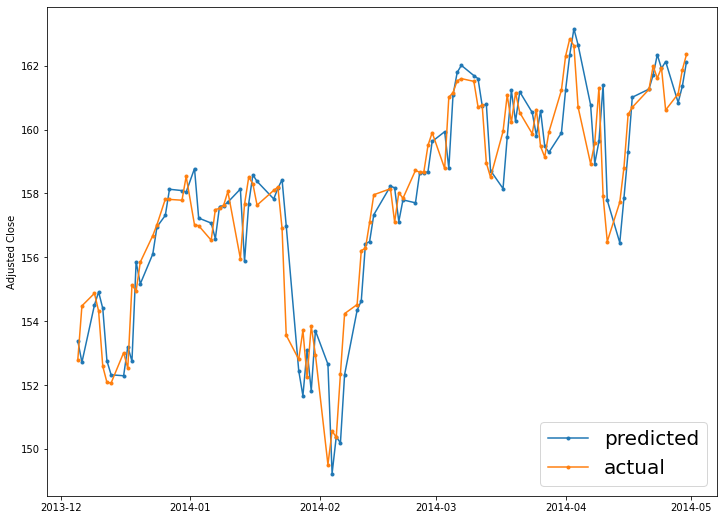

In [7]:
t.predict_next_n_days(n=100, begin_ind=5000, lag=50, show_plot=True)